<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DataAnalysis/blob/main/05.%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EA%B8%B0%EB%B0%98%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D/%ED%95%B4%EC%84%A4/ch05_12_%EC%82%AC%EC%9D%B4%ED%82%B7%EB%9F%B0%EC%8B%A4%EC%8A%B5_%EA%B2%80%EC%A6%9D%EA%B3%BC_%ED%95%98%EC%9D%B4%ED%8D%BC%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0_%ED%8A%9C%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch05.12. 사이킷런 실습 - 검증과 하이퍼파라미터 튜닝


---
* 날짜:
* 이름:

## 학습내용
    - 머신러닝 모델 성능 평가하기
    - 머신러닝 알고리즘에서 일반적으로 발생하는 문제 분석하기
    - 머신러닝 모델 세부 튜닝
    - 여러가지 성능 지표를 사용해 모델의 예측 성능 평가하기


## 학습자료
- [머신러닝 교과서 with파이썬, 사이킷런, 텐서플로](http://www.kyobobook.co.kr/product/detailViewKor.laf?mallGb=KOR&ejkGb=KOR&barcode=9791165215187)
- 6장. 모델 평가와 하이퍼파라미터 튜닝의 모범 사례

```
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 소개 : 위스콘신 유방암 데이터셋
---

* 악성과 양성인 종양 세포 샘플 569개
* 열0 : 샘플의 고유 ID
* 열1 : 진단 결과 {M: 악성, B: 양성}
* 열2 - 열 31 : 디지털 이미지에서 계산된 30개의 실수 값 특성



### | 데이터 준비

```
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)
```

* 데이터 로드 및 헤드 확인

In [3]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)
print(df.shape)
df.head(3)

(569, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


* y 클래스별 개수 시각화

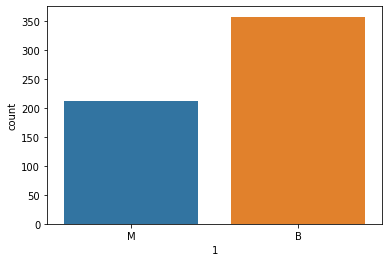

In [4]:
_=sns.countplot(data = df, x=1) # 불균형 클래스

### | 데이터 전처리

* 판다스에서 정수 인코딩 하기

In [5]:
# y값 (열1)을 B: 0(정상), M: 1(종양)
df[1].map({'B':0, 'M': 1})

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: 1, Length: 569, dtype: int64

* 사이킷런으로 정수 인코딩 하기

```
from sklearn.preprocessing import LabelEncoder
```


In [10]:
from sklearn.preprocessing import LabelEncoder

# 넘파이 변환
X = df.loc[:, 2:].values # 열 2~끝까지
y = df.loc[:, 1].values # 열1
print(X.shape, y.shape)
print(X[:2], y[:2])

# 정수 인코딩
le = LabelEncoder()
y = le.fit_transform(y) # 학습과 변환 
print(X.shape, y.shape)
print(X[:2], y[:2])
print('인코딩된 클래스 순서:', le.classes_)

(569, 30) (569,)
[[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
  1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
  6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
  1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
  4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 1.326e+03 8.474e-02 7.864e-02 8.690e-02
  7.017e-02 1.812e-01 5.667e-02 5.435e-01 7.339e-01 3.398e+00 7.408e+01
  5.225e-03 1.308e-02 1.860e-02 1.340e-02 1.389e-02 3.532e-03 2.499e+01
  2.341e+01 1.588e+02 1.956e+03 1.238e-01 1.866e-01 2.416e-01 1.860e-01
  2.750e-01 8.902e-02]] ['M' 'M']
(569, 30) (569,)
[[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
  1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
  6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
  1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
  4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 

* 샘플에 인코딩 적용

In [11]:
sample = ['M', 'B', 'B', 'M']
le.transform(sample)

array([1, 0, 0, 1])

* 데이터 분할

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y, # 분리시 y분포가 유사하도록
                                                    random_state=1 
                                                    )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

## 효과적인 모델 구상과 평가
---

### **| 모델 파이프라인 제작**

```
sklearn.pipeline.make_pipeline(*steps, 
                               memory=None, 
                               verbose=False)

```

* z-score 스케일링 -> 로지스틱 회귀

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
set_config(display='diagram')
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(random_state=1)
                        )
pipe_lr.fit(X_train, y_train)
pipe_lr

* z-score 스케일링 -> SVC

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import set_config
set_config(display='diagram')
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1)
                        )
pipe_svc.fit(X_train, y_train)
pipe_svc

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=1))])

* z-score 스케일링 -> PCA -> SVC

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import set_config
set_config(display='diagram')
pipe_pca_svc = make_pipeline(StandardScaler(),
                             PCA(n_components=2, random_state=1),
                             SVC(random_state=1)
                             )
pipe_pca_svc.fit(X_train, y_train)
pipe_pca_svc

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2, random_state=1)),
                ('svc', SVC(random_state=1))])

### **| k-겹 교차 검증을 사용한 모델 성능 평가**

#### **홀드아웃(holdout cross-validation)**

<p align='center'>
<img src=https://git.io/JtsTo?raw=true width=600>
</p>

* 초기 데이터셋을 별도의 훈련 데이터셋과 테스트 데이터셋으로 분리
* 성능 향상을 위해 하이퍼파라미터를 튜닝하고 비교하는 과정을 모델 선택이라고 한다.
* 하이퍼파라미터 튜닝의 기준은 테스트셋이고 따라서 하이퍼파라미터를 튜닝하는 과정에서 테스트셋도 모델 선택의 일부가 되버린다.
* 홀드아웃 방법은 데이터를 훈련 데이터, 검증 데이터, 테스트 데이터셋 세가지로 나누는 것. 
* 훈련 데이터셋 : 학습 파라미터 조정
* 검증 데이터셋 : 하이퍼 파라미터 조정
* 테스트 데이터셋 : 최종 성능 평가

#### **k-겹 교차검증(k-fold cross-validation)**

<p align='center'>
<img src=https://git.io/JtsT6?raw=true width=600>
</p>


* 중복을 허용하지 않고 훈련 데이터셋을 k개의 폴드로 랜덤하게 나눈다.
* k-1개의 폴드로 모델 훈련을 k번 하여 k개의 모델 확보
* k개 모델에 대한 k번의 성능 평가 진행
* 일반적으로 최적의 하이퍼파라미터 값을 찾기 위해 사용
* 최적의 하이퍼파라미터를 찾은 후에는 전체 훈련 데이터셋을 사용해 모델을 재훈련
* 최종 성능 추정은 독립적인 테스트셋(이제껏 사용하지 않은 데이터)을 사용하여 추정.


```
sklearn.model_selection.cross_validate(estimator, # 모델
                                       X, y=None, 데이터
                                       groups=None,
                                       scoring=None, 
                                       cv=None, # corss-validation 교차검증, k 
                                       n_jobs=None,
                                       verbose=0,
                                       fit_params=None,
                                       pre_dispatch='2*n_jobs', 
                                       return_train_score=False, 
                                       return_estimator=False, 
                                       error_score=nan)
```

In [ ]:
train.csv -> 정답이 있다.
train.csv -> train : 모델 학습
          -> valid : 파라미터 튜닝 및 평가

test.csv -> 정답이 없고 : 최종성능 (리더보드 제출)

# 지금 데이터에서, 
x_train, x_valid,  y_train, y_valid = train_test_split(x_train, y_train) -> 홀드아웃방식
cross_validate(x_train, y_train) -> k겹 교차방식.

In [24]:
from sklearn.model_selection import cross_validate

df = pd.DataFrame()
for pipe in ['pipe_lr', 'pipe_svc', 'pipe_pca_svc']:
  scores = cross_validate(estimator = eval(pipe),
                          X = X_train, 
                          y = y_train,
                          scoring=['accuracy'],
                          cv = 10
                          )
  df[pipe] = scores['test_accuracy']
  mean_score = np.mean(scores['test_accuracy']).round(3)
  print(f'{pipe} 평균성능 : {mean_score}')

pipe_lr 평균성능 : 0.98
pipe_svc 평균성능 : 0.978
pipe_pca_svc 평균성능 : 0.932


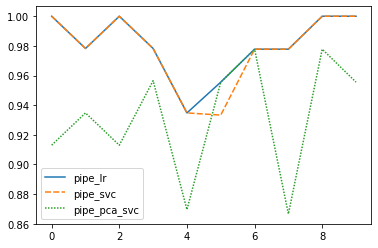

In [28]:
_=sns.lineplot(data=df)

## 머신러닝 성능향상을 위한 디버깅과 튜닝
---

### **| 알고리즘 디버깅**



#### **학습 곡선**

    - 주어진 훈련 데이터셋에 비해 모델이 너무 복잡하면 모델이 과대적합되고 처음 본 데이터에 잘 일반화 되지 못하는 경향이 생긴다.
    - 이를 해결하는 가장 효과적인 방법은 훈련 샘플을 더 모으기
    - 하지만 데이터를 모으는 비용과 시간이 소요되기 때문에 훈련 정확도와 검증 정확도를 훈련 데이터 셋 크기 함수로 그래프를 그린다.



<p align='center'>
<img src=https://git.io/JtsTi?=true width=600>
</p>


    과소 적합 
      - 훈련 정확도와 테스트 정확도가 모두 낮다
      - 일반적으로 모델이 훈련 데이터에 대해서도 학습을 못한 상태
      - 이를 해결하기 위한 일반적인 방법


    과대 적합
      - 훈련 정확도와 테스트 정확도의 차이가 큼
      - 모델이 테스트 데이터에 대해 일반화(generaliztion)을 하지 못하는 상태
      - 이를 해결하기 위한 일반적인 방법





```
sklearn.model_selection.learning_curve(estimator, 
                                      X, y, 
                                      groups=None
                                      train_sizes=array([0.1, 0.33, 0.55, 0.78, 1.]), 
                                      cv=None, 
                                      scoring=None,
                                      exploit_incremental_learning=False, 
                                      n_jobs=None, pre_dispatch='all', 
                                      verbose=0, 
                                      shuffle=False, 
                                      random_state=None, 
                                      error_score=nan, 
                                      return_times=False, 
                                      fit_params=None)[source]
```

* 시각화

* 생성한 파이프라인에 대한 학습 곡선 시각화

#### **검증 곡선**


* x축 : 
* y축 :


```
sklearn.model_selection.validation_curve(estimator, 
                                        X, y, *, 
                                        param_name, 
                                        param_range,
                                        groups=None, 
                                        cv=None, 
                                        scoring=None,
                                        n_jobs=None,
                                        pre_dispatch='all', 
                                        verbose=0, 
                                        error_score=nan, 
                                        fit_params=None)[source]
```

* 시각화


### **| 하이퍼파라미터 튜닝**


    - 머신 러닝에는 두가지 파라미터가 존재
    * 학습 파라미터 
      * 훈련 데이터를 통해 모델 알고리즘이 자동으로 학습되는 데이터
      * 로지스틱 회귀의 가중치 

    * 하이퍼파라미터 
      * 로지스틱 회귀의 규제 매개변수
      * 결정트리의 깊이


#### **그리드 서치를 사용한 하이퍼파라미터 튜닝**

```
class sklearn.model_selection.GridSearchCV(estimator,
                                           param_grid,
                                           scoring=None,
                                           n_jobs=None,
                                           refit=True,
                                           cv=None, 
                                           verbose=0,
                                           pre_dispatch='2*n_jobs', 
                                           error_score=nan, 
                                           return_train_score=False)
```

* pipe_pcasvc 그리드 서치 진행하기

## 여러가지 성능 평가 지표
---


### | 오차행렬 (confusion matrix)

<p align='center'>
<img src=https://git.io/JtsT1?=true width=400>
</p>

* 함수구현

* 시각화

#### **예측 오차와 예측 정확도**

* 예측 오차
\begin{split}
ERR = \frac{잘못된 예측 개수}{전체 샘플 개수}
\end{split}

* 예측 정확도

\begin{split}
ACC = \frac{잘된 예측 개수}{전체 샘플 개수} = 1-ERR
\end{split}

### **| 분류 모델의 성능 최적화**


#### **TPR (True Positive Rate), FPR (False Positive Rate)**

* TPR

\begin{split}
TPR = \frac{TP}{P} = \frac{TP}{FN+TP} = \frac{모델이 True로 예측한 샘플}{실제 True인 샘플}
\end{split}

* FPR

\begin{split}
FPR = \frac{FP}{N} = \frac{FP}{FP+TN} = \frac{모델이 True로 예측한 샘플}{실제 False인 샘플}
\end{split}

\begin{split}
\end{split}

    - TPR과 FPR은 클래스 비율이 다른 경우 유용한 성능 지표
    - 종양진단 문제에서 환자가 적절한 치료를 받을 수 있도록 악성 종양을 감지하는데 관심이 있다.(악성을 악성으로 구분, TN)
    - 불필요하게 환자에게 걱정을 끼치지 않도록 양성 샘플을 악성 샘플로 분류되는 경우(FP)를 줄이는것이 중요


#### **정밀도 (Precisison)와 재현율(Recall)**

* 정밀도

\begin{split}
PRE =  \frac{TP}{TP+FP} = \frac{실제로  True인 샘플}{모델이 True로 예측한 샘플}
\end{split}

* 재현율

\begin{split}
REC = TPR = \frac{모델이 True로 예측한 샘플}{실제 False인 샘플}
\end{split}

\begin{split}
\end{split}


    - 정밀도로 모델을 최적화 하면 생기는 일
      * 모델이 정상군을 정상이라고 판단하도록 한다.
      * 정상군을 감지하는데 효과적
      * 악성 종양을 정상으로 잘못 판단 할 수 있다. 

    - 재현율로 모델을 최적화 하면 생기는 일
      * 모델이 악성 종양을 정상이라고 판단하는 경우를 최소화 하게 된다. 
      * 악성 종양을 감지하는데 효과적
      * 정상군도 악성 종양으로 잘못 판단 할 수 있다. 



#### **F1-score**

\begin{split}
F1 = 2\frac{PRE \times REC}{PRE+REC}
\end{split}


#### **AUC**

### **| 성능 평가 기준 바꿔서 검증하기**

* pipe_pcasvc 그리드 서치 진행하기, 성능은 AUC

### | ROC (Receiver Operating Characteristic)

    - 분류기의 임계값을 바꾸어 가며 계산된 fPR과 TPR 점수를 시각화한 플롯

    - ROC그래프의 대각선은 랜덤 추측인 경우이며 완벽한 분류기라면 왼쪽 위를 향하는 그래프가 그려진다.

    - ROC곡선의 아래 면적을 ROC AUC (ROC Area Under the Curve) 라 하며 성능 지표로 사용된다.



### **| 다중 분류의 성능 지표**


\begin{split}
\end{split}

* 마크로 평균 

\begin{split}
PRE_{macro} = \frac{PRE_1 + ... PRE_k}{k}
\end{split}


* 마이크로 평균 

\begin{split}
PRE_{micro} = \frac{TP_1 + ... TP_k}{TP_1 + ...+ TP_k + FP_1 +  ... + FP_k}
\end{split}

\begin{split}
\end{split}


    - 마크로 평균 방식에서는 가장 빈도 높은 클래스 레이블의 성능이 영향을 미치게 된다.

    - 마이크로 평균은 각 샘플이나 예측에 동일한 가중치를 부여

    - 사이킷런에서 다중 분류 모델을 평가하면 정규화 또는 가중치가 적용된 마크로 평균이 기본적으로 적용된다.

    - 마크로 평균은 샘플 개수에 가중치가 부여되므로 레이블마다 샘플 개수가 다른 불균형한 클래스를 다룰 때 유용
